# Volatilty of IBOVESPA Stock Market Returns during COVID-19  

Importing Necessary Libraries 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import het_arch

### Data Collection

In [20]:
stock_data = pd.read_csv('/Users/laura-alaerebrown/BrazilStockMarket.csv', parse_dates=['Date'])
covid_data = pd.read_csv('/Users/laura-alaerebrown/BrazilCOVIDCases.csv', parse_dates=['Date'])

/var/folders/4g/99mtg__52b13zvyv_8rp52jh0000gn/T/ipykernel_68639/4201288476.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stock_data = pd.read_csv('/Users/laura-alaerebrown/BrazilStockMarket.csv', parse_dates=['Date'])
/var/folders/4g/99mtg__52b13zvyv_8rp52jh0000gn/T/ipykernel_68639/4201288476.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  covid_data = pd.read_csv('/Users/laura-alaerebrown/BrazilCOVIDCases.csv', parse_dates=['Date'])


In [21]:
# Set the Date column as the index
stock_data.set_index('Date', inplace=True)
covid_data.set_index('Date', inplace=True)

In [22]:
stock_data.sort_index(inplace=True)
covid_data.sort_index(inplace=True)

In [23]:
start_date = '2019-01-01'
end_date = '2020-06-30'
stock_data = stock_data.loc[start_date:end_date]
covid_data = covid_data.loc[start_date:end_date]

### Plotting Time Series Data 

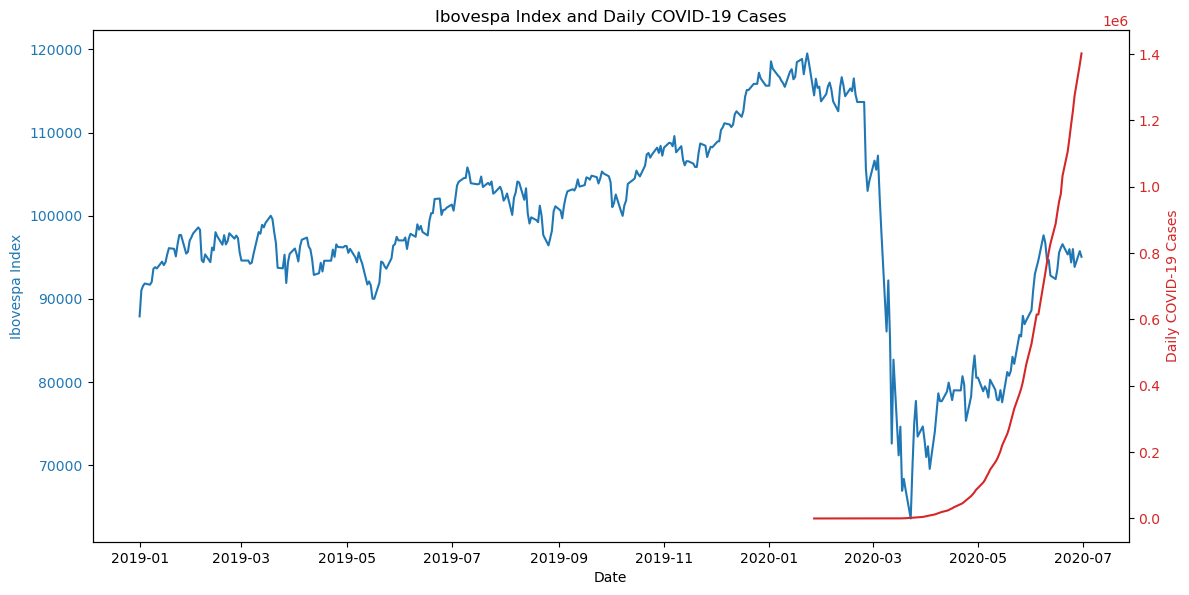

In [24]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Ibovespa Index', color='tab:blue')
ax1.plot(stock_data.index, stock_data['Close'], color='tab:blue', label='Ibovespa Index')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Daily COVID-19 Cases', color='tab:red')
ax2.plot(covid_data.index, covid_data['Cases'], color='tab:red', label='Daily COVID-19 Cases')
ax2.tick_params(axis='y', labelcolor='tab:red')
fig.tight_layout()
plt.title('Ibovespa Index and Daily COVID-19 Cases')
plt.show()

###   Log Return

In [25]:
stock_data['Return'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
stock_data.dropna(inplace=True)

In [26]:
stock_data['Return']

Date
2019-01-02    0.034940
2019-01-03    0.006046
2019-01-04    0.003016
2019-01-07   -0.001545
2019-01-08    0.003623
                ...   
2020-06-24   -0.016788
2020-06-25    0.016871
2020-06-26   -0.022640
2020-06-29    0.020055
2020-06-30   -0.007123
Name: Return, Length: 390, dtype: float64

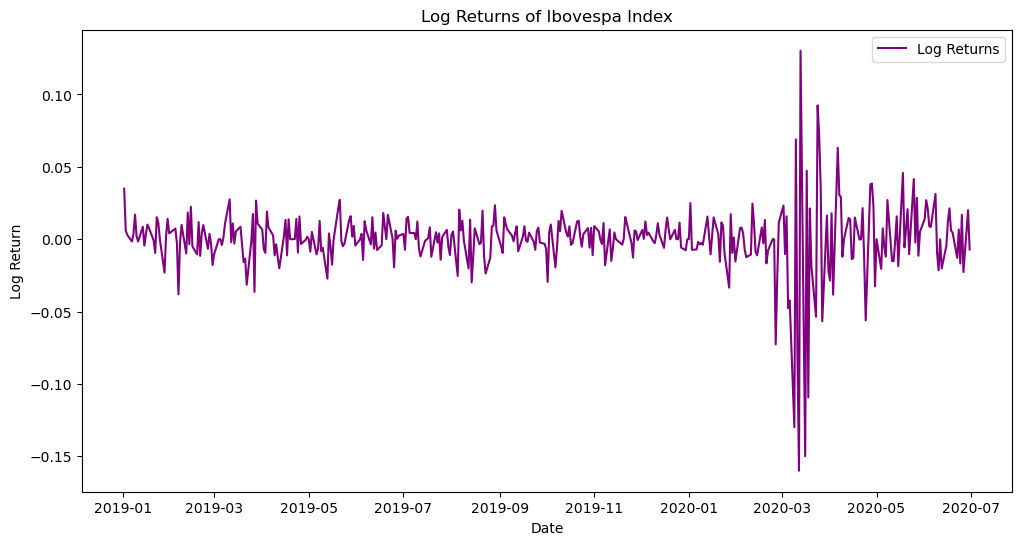

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Return'], color='purple', label='Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.title('Log Returns of Ibovespa Index')
plt.legend()
plt.show()

### Descriptive Statistics

In [28]:
desc_stats = stock_data['Return'].describe()
desc_stats.loc['skewness'] = stock_data['Return'].skew()
desc_stats.loc['kurtosis'] = stock_data['Return'].kurtosis()

In [29]:
jb_test = jarque_bera(stock_data['Return'].dropna())
desc_stats['jarque_bera'] = jb_test[0]
desc_stats['jb_pvalue'] = jb_test[1]

In [30]:
print("Descriptive Statistics:\n", desc_stats)

Descriptive Statistics:
 count           390.000000
mean              0.000201
std               0.023242
min              -0.159938
25%              -0.007109
50%               0.000305
75%               0.009510
max               0.130228
skewness         -1.705638
kurtosis         16.416514
jarque_bera    4447.796909
jb_pvalue         0.000000
Name: Return, dtype: float64


### Unit Root Test (ADF Test)

In [31]:
adf_test = adfuller(stock_data['Return'].dropna())
print("\nADF Test:\n")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
for key, value in adf_test[4].items():
    print('Critical Values:')
    print(f"   {key}, {value}")


ADF Test:

ADF Statistic: -5.204777098407453
p-value: 8.596776304687104e-06
Critical Values:
   1%, -3.4478152097574224
Critical Values:
   5%, -2.8692371153451903
Critical Values:
   10%, -2.5708704003405356


### ARCH Effect Test 

In [32]:
arch_test = het_arch(stock_data['Return'].dropna())
print("\nARCH Test:\n")
print(f"ARCH Test Statistic: {arch_test[0]}")
print(f"p-value: {arch_test[1]}")


ARCH Test:

ARCH Test Statistic: 189.17804147094495
p-value: 2.898812750670715e-35


### Creation of COVID 19 dummy variable

In [33]:
covid_data['COVID_Dummy'] = 0
covid_data.loc['2020-01-01':, 'COVID_Dummy'] = 1

In [34]:
covid_dummy_series = pd.Series(0, index=stock_data.index)
covid_dummy_series.loc['2020-01-01':] = 1

### GARCH (1,1) model

In [35]:
model_garch = arch_model(stock_data['Return'].dropna(), vol='Garch', p=1, q=1)
model_garch_fit = model_garch.fit(disp='off')
print("\nGARCH(1,1) Model Summary:\n", model_garch_fit.summary())


GARCH(1,1) Model Summary:
                      Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1080.72
Distribution:                  Normal   AIC:                          -2153.44
Method:            Maximum Likelihood   BIC:                          -2137.57
                                        No. Observations:                  390
Date:                Sun, Jul 14 2024   Df Residuals:                      389
Time:                        14:23:00   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.4107e-03  7.196e-

/Users/laura-alaerebrown/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005388. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


### GARCH (1,1) model with Exogenous Variable

In [36]:
model_garch_exog = arch_model(stock_data['Return'].dropna(), vol='Garch', p=1, q=1, x=covid_dummy_series)
model_garch_exog_fit = model_garch_exog.fit(disp='off')
print("\nGARCH(1,1) Model with Exogenous Variable Summary:\n", model_garch_exog_fit.summary())


GARCH(1,1) Model with Exogenous Variable Summary:
                      Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1080.72
Distribution:                  Normal   AIC:                          -2153.44
Method:            Maximum Likelihood   BIC:                          -2137.57
                                        No. Observations:                  390
Date:                Sun, Jul 14 2024   Df Residuals:                      389
Time:                        14:23:19   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu    

/Users/laura-alaerebrown/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005388. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


### Conditional Volatility of both models (GARCH (1,1) model + GARCH (1,1) model with Exogenous Variable)

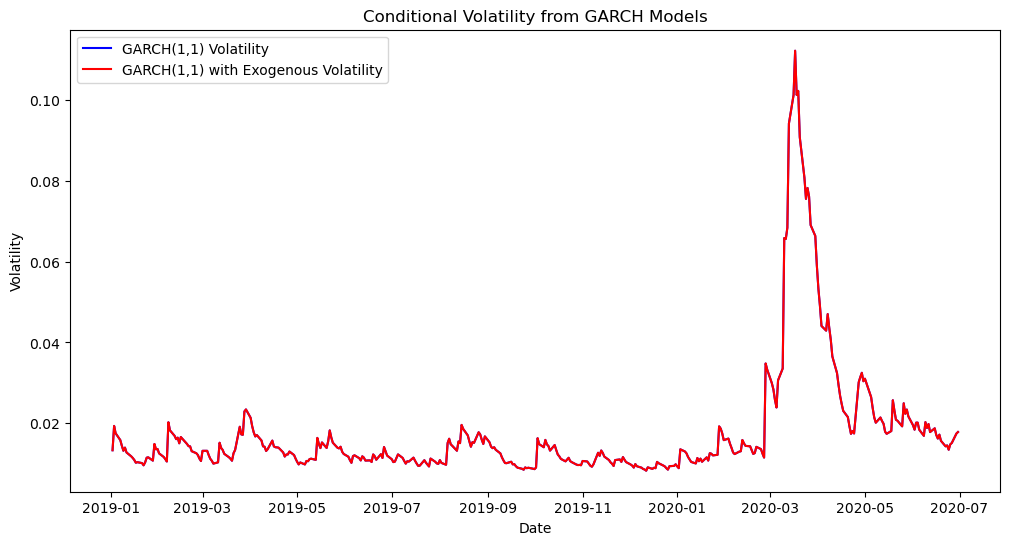

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(model_garch_fit.conditional_volatility, color='blue', label='GARCH(1,1) Volatility')
plt.plot(model_garch_exog_fit.conditional_volatility, color='red', label='GARCH(1,1) with Exogenous Volatility')
plt.title('Conditional Volatility from GARCH Models')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()